In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from numba import jit
from scipy import stats
import networkx as nx
import random
import re
from validation_functions import *
from numba import njit

sys.path.append("../scripts/")
from node_classification_all_models import *
from loader_utils import *

plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

/home/rob/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rob/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rob/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopyth

In [2]:
def extract_time(path):
    extract_line = lambda line: float(line.strip().split(":")[-1].split()[0])
    with open(path, "r") as f:
        total_time = -1
        initalization_time = -1
        inference_time = -1
        initial_positions_time = -1
        refining_time = -1
        adjusting_time = -1
        for line in f:
            if "Elapsed CPU time (embedding):" in line:
                total_time = extract_line(line)
            elif "initialization:" in line:
                initalization_time = extract_line(line)
            elif "parameters inference:" in line:
                inference_time = extract_line(line)
            elif "initial positions:" in line:
                initial_positions_time = extract_line(line)
            elif "refining positions:" in line:
                refining_time = extract_line(line)
            elif "adjusting kappas:" in line:
                adjusting_time = extract_line(line)
        return total_time, initalization_time, inference_time, initial_positions_time, refining_time, adjusting_time


def check_file(path):
    with open(path, "r") as f:
        for line in f:
            if "More than one component found!!" in line:
                return False
    return True
    
def average_extract_time(folder_path):
    all_times = []
    for p in glob.glob(f"{folder_path}/*.inf_log"):
        if check_file(p):
            all_times.append(extract_time(p))
    return np.array(all_times)

In [3]:
base_path = "/home/rob/MEGAsync/datasets/networks/Synthetic/fix_slow_version/f-mercator-networks/paper_simulations/validation/time_complexity/"


dimensions = [1, 2]
ntimes = 10
Nf = [100, 500, 1000, 2000, 5000, 10000]

res = {}

counter = 0
for i in range(ntimes):
    for d in dimensions:
        for n in Nf:
            p = f'{base_path}/dim_2_B_s_3_g_s_2.7_Ns_obs_{n}_k_s_10_g_n_2.7_k_n_10_g_f_2.7_N_f_{n}_B_bi_2_c_0.0_i_{i}/eS{d}'
        
            try:
                vals = average_extract_time(p)
                res[(n, d, i)] = vals[0]
                
            except Exception:
                print(p)
                counter += 1
                continue
                
counter

0

In [4]:
df = pd.DataFrame(res).T.reset_index()
df.columns = [r'$N_f$', 'D', 'i', 'total_time', 'initialization', 'param_inference',
              'initial_pos','refining', 'adjusting_kappas']
df.head()

,$N_f$,D,i,total_time,initialization,param_inference,initial_pos,refining,adjusting_kappas
0,100,1,0,0.8449,0.0278,0.4316,0.0779,0.3059,0.0017
1,500,1,0,12.0181,0.1935,2.7513,0.1638,8.8580,0.0516
2,1000,1,0,43.2220,0.4408,3.4615,0.2738,38.7836,0.2621
3,2000,1,0,178.6713,1.7345,4.3489,0.7519,170.7860,1.0500
4,5000,1,0,1306.6591,7.0706,65.3218,3.4208,1208.6186,22.2273


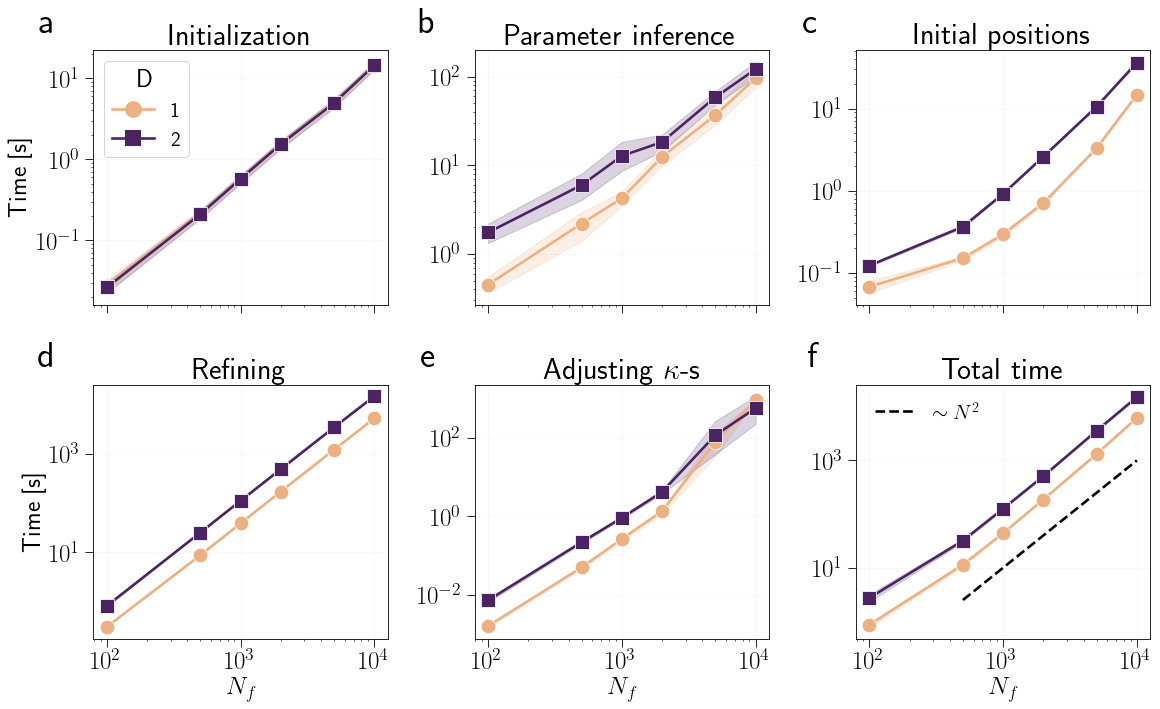

In [15]:
x = np.linspace(500, 10000)
y = x ** 2 / 1e5

fig, axs = plt.subplots(2, 3, sharex=True, figsize=(16, 10))

markers = {1: 'o', 2: 's'}

sns.lineplot(data=df, x='$N_f$', y='initialization', hue='D', style='D', 
             ax=axs[0,0], markers=markers, dashes=False, palette="flare")
axs[0, 0].set_ylabel('Time [s]')
axs[0, 0].set_yscale('log')
axs[0, 0].set_title('Initialization')
axs[0, 0].grid(alpha=0.1)

sns.lineplot(data=df, x='$N_f$', y='param_inference', hue='D', style='D',
             markers=markers, ax=axs[0,1], dashes=False, palette="flare")
axs[0, 1].set_ylabel('')
axs[0, 1].set_yscale('log')
axs[0, 1].set_title('Parameter inference')
axs[0, 1].legend('', frameon=False)
axs[0, 1].grid(alpha=0.1)

sns.lineplot(data=df, x='$N_f$', y='initial_pos', hue='D', style='D',
             markers=markers, ax=axs[0,2], marker='o', dashes=False, palette="flare")
axs[0, 2].set_ylabel('')
axs[0, 2].set_yscale('log')
axs[0, 2].set_title('Initial positions')
axs[0, 2].legend('', frameon=False)
axs[0, 2].grid(alpha=0.1)

sns.lineplot(data=df, x='$N_f$', y='refining', hue='D', style='D',
             markers=markers, ax=axs[1, 0], marker='o', dashes=False, palette="flare")
axs[1, 0].set_ylabel('Time [s]')
axs[1, 0].set_yscale('log')
axs[1, 0].set_title('Refining')
axs[1, 0].legend('', frameon=False)
axs[1, 0].grid(alpha=0.1)

sns.lineplot(data=df, x='$N_f$', y='adjusting_kappas', hue='D', style='D',
             markers=markers, ax=axs[1, 1], marker='o', dashes=False, palette="flare")
axs[1, 1].set_ylabel('')
axs[1, 1].set_yscale('log')
axs[1, 1].set_title(r'Adjusting $\kappa$-s')
axs[1, 1].legend('', frameon=False)
axs[1, 1].grid(alpha=0.1)

sns.lineplot(data=df, x='$N_f$', y='total_time', hue='D', style='D',
             markers=markers, ax=axs[1, 2], marker='o', dashes=False, 
             palette="flare", legend=False)
axs[1, 2].set_yscale('log')
axs[1, 2].set_xscale('log')
axs[1, 2].set_ylabel('')
axs[1, 2].set_title(r'Total time')
axs[1, 2].plot(x, y, label=r'$\sim N^2$', color='xkcd:black', linestyle='--')
axs[1 ,2].legend(frameon=False)
axs[1, 2].grid(alpha=0.1)


letters = ['a', 'b', 'c', 'd', 'e', 'f']
positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
for idx, (i, j) in enumerate(positions):
    axs[i, j].text(-0.13, 1.17, letters[idx], transform=axs[i, j].transAxes, 
                   fontsize=35, fontweight='bold', va='top', ha='right')

plt.tight_layout()
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/time_complexity.pdf")